<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/example/SimulationTEG_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Simulation of a TEG dehydration process
In this notebook we will establish code for using NeqSim for simulation of a TEG dehydration process.

In [ ]:
# Setting up the Colab page to use neqsim
%%capture
!pip install neqsim==2.5.35
import neqsim
from neqsim.thermo.thermoTools import *

# Process flow diagram

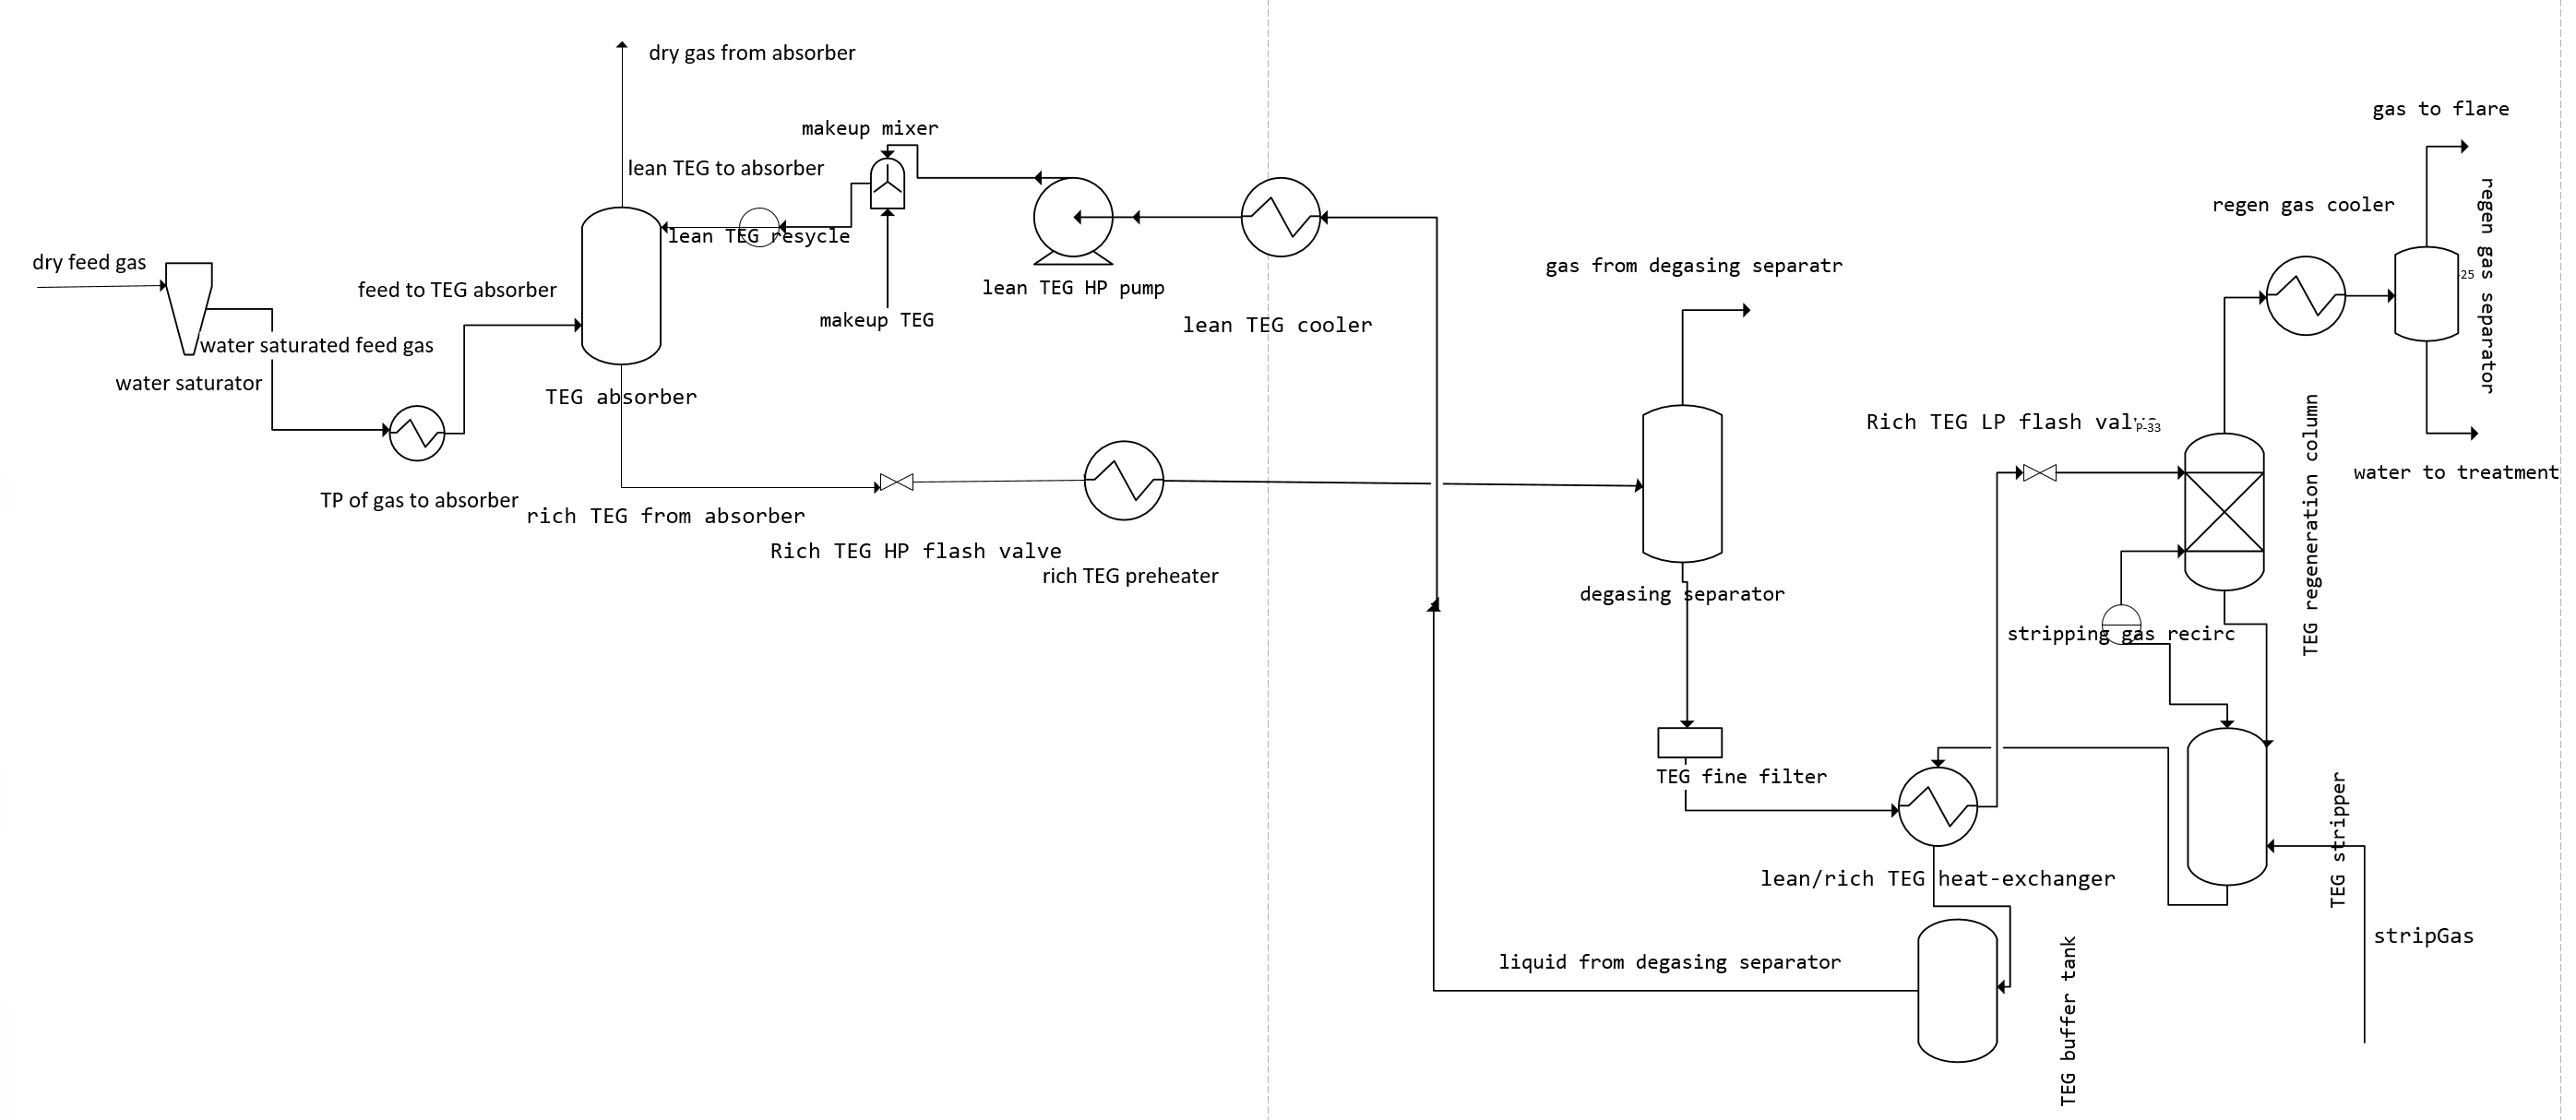

# Seting up the process in Python code


In [ ]:
#Input parameters
inputData = {
  "feedGasFlowRate": 6.0, #MSm3/day
  "feedGasTemperature": 25.0, #C
  "feedGasPressure":70.0, #bara
  "absorberFeedGasTemperature": 35.0, #C
  "absorberFeedGasPressure": 139.0, #bara
  "leanTEGFlowRate": 6100.0, #kg/hr
  "leanTEGTemperature": 48.5, #C
  "flashDrumPressure": 4.8, #bara
  'reboilerPressure': 1.2, #bara
  'condenserPressure':  1.2, #bara
  'condenserTemperature': 100.0, #C
  'reboilerTemperature': 200.0, #C
  'strippingGasRate': 180.0, #kg/hr
  "strippingGasFeedTemperature": 80.0, #C
  'bufferTankTemperatureTEG': 90.5,
  'hotTEGpumpPressure': 3.0, #bara
  "regenerationGasCoolerTemperature": 50.0, #C
  'finefilterdeltaP': 0.01, #bara
  "numberOfStagesTEGabsorber": 4,
  "stageEfficiencyTEGabsorber": 0.7, #[-]
  "numberOfStagesStripper": 4,
  "stageEfficiencyStripper": 0.68, #[-]
  "UAvalueLeanRichTEGHeatExchanger": 8316.0, #W/K
  "UAvalueLeanRichTEGHeatExchanger2": 2224.0 #W/K
}

In [ ]:
from neqsim.thermo import fluid, printFrame
from neqsim.process import getProcess, clearProcess, mixer, heater, stream, pump, separator, runProcess, stream, saturator, valve, filters, heatExchanger, simpleTEGAbsorber,distillationColumn, waterStripperColumn, recycle2, setpoint, calculator

clearProcess()

# Start by creating a fluid in neqsim
feedGas = fluid("cpa")  # create a fluid using the SRK-Eo
feedGas.addComponent("nitrogen", 0.245);
feedGas.addComponent("CO2", 3.4);
feedGas.addComponent("methane", 85.7);
feedGas.addComponent("ethane", 5.981);
feedGas.addComponent("propane", 2.743);
feedGas.addComponent("i-butane", 0.37);
feedGas.addComponent("n-butane", 0.77);
feedGas.addComponent("i-pentane", 0.142);
feedGas.addComponent("n-pentane", 0.166);
feedGas.addComponent("n-hexane", 0.06);
feedGas.addComponent("benzene", 0.01);
feedGas.addComponent("water", 0.0);
feedGas.addComponent("TEG", 0);
feedGas.setMixingRule(10)
feedGas.setMultiPhaseCheck(False)
feedGas.init(0)

dryFeedGas = stream(feedGas)
dryFeedGas.setName('dry feed gas')
dryFeedGas.setFlowRate(inputData['feedGasFlowRate'], 'MSm3/day')
dryFeedGas.setTemperature(inputData['feedGasTemperature'], 'C')
dryFeedGas.setPressure(inputData['feedGasPressure'], 'bara')

saturatedFeedGas = saturator(dryFeedGas)
saturatedFeedGas.setName("water saturator")

waterSaturatedFeedGas = stream(saturatedFeedGas.getOutStream())
waterSaturatedFeedGas.setName("water saturated feed gas")

feedTEG = feedGas.clone()
feedTEG.setMolarComposition([0.0,0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,0.015, 0.985])

feedTPsetterToAbsorber = heater(waterSaturatedFeedGas)
feedTPsetterToAbsorber.setName('TP of gas to absorber')
feedTPsetterToAbsorber.setOutPressure(inputData['absorberFeedGasPressure'], "bara")
feedTPsetterToAbsorber.setOutTemperature(inputData['absorberFeedGasTemperature'], "C")

feedToAbsorber = stream(feedTPsetterToAbsorber.getOutStream())
feedToAbsorber.setName("feed to TEG absorber")

TEGFeed = stream(feedTEG)
TEGFeed.setName('lean TEG to absorber')
TEGFeed.setFlowRate(inputData['leanTEGFlowRate'], 'kg/hr')
TEGFeed.setTemperature(inputData['leanTEGTemperature'], 'C')
TEGFeed.setPressure(inputData['absorberFeedGasPressure'], 'bara')

absorber = simpleTEGAbsorber()
absorber.setName("TEG absorber")
absorber.addGasInStream(feedToAbsorber)
absorber.addSolventInStream(TEGFeed)
absorber.setNumberOfStages(inputData['numberOfStagesTEGabsorber'])
absorber.setStageEfficiency(inputData['stageEfficiencyTEGabsorber'])

dehydratedGas = stream(absorber.getGasOutStream())
dehydratedGas.setName('dry gas from absorber')

richTEG = stream(absorber.getSolventOutStream())
richTEG.setName("rich TEG from absorber")

glycol_flash_valve = valve(richTEG)
glycol_flash_valve.setName("Rich TEG HP flash valve")
glycol_flash_valve.setOutletPressure(inputData['flashDrumPressure'])

richGLycolHeaterCondenser = heater(glycol_flash_valve.getOutStream())
richGLycolHeaterCondenser.setName("rich TEG preheater")

heatEx2 = heatExchanger(richGLycolHeaterCondenser.getOutStream())
heatEx2.setName("cold lean/rich TEG heat-exchanger")
heatEx2.setGuessOutTemperature(273.15 + 60.0)
heatEx2.setUAvalue(inputData['UAvalueLeanRichTEGHeatExchanger2'])

flashSep = separator(heatEx2.getOutStream(0))
flashSep.setName("degasing separator")

flashGas = stream(flashSep.getGasOutStream())
flashGas.setName("gas from degasing separator")

flashLiquid = stream(flashSep.getLiquidOutStream())
flashLiquid.setName("liquid from degasing separator")

fineFilter = filters(flashLiquid)
fineFilter.setName("TEG fine filter")
fineFilter.setDeltaP(inputData['finefilterdeltaP'], "bara")

heatEx = heatExchanger(fineFilter.getOutStream())
heatEx.setName("lean/rich TEG heat-exchanger")
heatEx.setGuessOutTemperature(273.15 + 130.0)
heatEx.setUAvalue(inputData['UAvalueLeanRichTEGHeatExchanger'])

glycol_flash_valve2 = valve(heatEx.getOutStream(0))
glycol_flash_valve2.setName("Rich TEG LP flash valve")
glycol_flash_valve2.setOutletPressure(inputData['reboilerPressure'])

stripGas = feedGas.clone()

strippingGas = stream(stripGas)
strippingGas.setName('stripGas')
strippingGas.setFlowRate(inputData['strippingGasRate'], "Sm3/hr")
strippingGas.setTemperature(inputData['strippingGasFeedTemperature'], "C")
strippingGas.setPressure(inputData['reboilerPressure'], "bara")

gasToReboiler = strippingGas.clone()
gasToReboiler.setName("gas to reboiler")

column = distillationColumn(1, True, True)
column.setName("TEG regeneration column")
column.addFeedStream(glycol_flash_valve2.getOutStream(), 1)
column.getReboiler().setOutTemperature(273.15 + inputData['reboilerTemperature'])
column.getCondenser().setOutTemperature(273.15 + inputData['condenserTemperature'])
column.getTray(1).addStream(gasToReboiler)
column.setTopPressure(inputData['condenserPressure'])
column.setBottomPressure(inputData['reboilerPressure'])

coolerRegenGas = heater(column.getGasOutStream())
coolerRegenGas.setName("regen gas cooler")
coolerRegenGas.setOutTemperature(273.15 + inputData['regenerationGasCoolerTemperature'])

sepregenGas = separator(coolerRegenGas.getOutStream())
sepregenGas.setName("regen gas separator");

gasToFlare = stream(sepregenGas.getGasOutStream())
gasToFlare.setName("gas to flare");

liquidToTrreatment = stream(sepregenGas.getLiquidOutStream())
liquidToTrreatment.setName("water to treatment")

stripper = waterStripperColumn("TEG stripper")
stripper.addSolventInStream(column.getLiquidOutStream())
stripper.addGasInStream(strippingGas)
stripper.setNumberOfStages(inputData['numberOfStagesStripper'])
stripper.setStageEfficiency(inputData['stageEfficiencyStripper'])

recycleGasFromStripper = recycle2("stripping gas recirc")
recycleGasFromStripper.addStream(stripper.getGasOutStream())
recycleGasFromStripper.setOutletStream(gasToReboiler)

heatEx.setFeedStream(1, stripper.getSolventOutStream())

bufferTank = heater(heatEx.getOutStream(1))
bufferTank.setName("TEG buffer tank")
bufferTank.setOutTemperature(273.15 + inputData['bufferTankTemperatureTEG'])

hotLeanTEGPump = pump(bufferTank.getOutStream(),inputData['hotTEGpumpPressure'],"lean TEG LP pump")

heatEx2.setFeedStream(1, hotLeanTEGPump.getOutStream())

coolerhOTteg3 = heater(heatEx2.getOutStream(1))
coolerhOTteg3.setName("lean TEG cooler")
coolerhOTteg3.setOutTemperature(273.15 + inputData['leanTEGTemperature'])

hotLeanTEGPump2 = pump(coolerhOTteg3.getOutStream(), inputData['absorberFeedGasPressure'], "lean TEG HP pump")
hotLeanTEGPump2.setName("lean TEG HP pump")
hotLeanTEGPump2.setOutletPressure(inputData['absorberFeedGasPressure'])

pumpHPPresSet = setpoint("HP pump set", hotLeanTEGPump2, "pressure", feedToAbsorber)

leanTEGtoabs = stream(hotLeanTEGPump2.getOutStream())
leanTEGtoabs.setName("lean TEG to absorber")

pureTEG = feedGas.clone()
pureTEG.setMolarComposition([0.0,0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0])

makeupTEG = stream(pureTEG)
makeupTEG.setName("makeup TEG")
makeupTEG.setFlowRate(1e-6, "kg/hr")
makeupTEG.setTemperature(inputData['leanTEGTemperature'], "C")
makeupTEG.setPressure(inputData['absorberFeedGasPressure'], "bara")

makeupCalculator = calculator("TEG makeup calculator")
makeupCalculator.addInputVariable(dehydratedGas)
makeupCalculator.addInputVariable(flashGas)
makeupCalculator.addInputVariable(gasToFlare)
makeupCalculator.addInputVariable(liquidToTrreatment)
makeupCalculator.setOutputVariable(makeupTEG)

makeupMixer = mixer("makeup mixer")
makeupMixer.addStream(leanTEGtoabs)
makeupMixer.addStream(makeupTEG)

resycleLeanTEG = recycle2("lean TEG resycle")
resycleLeanTEG.addStream(makeupMixer.getOutStream())
resycleLeanTEG.setOutletStream(TEGFeed)
resycleLeanTEG.setPriority(200)
resycleLeanTEG.setDownstreamProperty("flow rate")

richGLycolHeaterCondenser.setEnergyStream(column.getCondenser().getEnergyStream())

TEGprocess = getProcess()


# Start simulation

In [ ]:
#thread = TEGprocess.run()
thread = TEGprocess.runAsThread()

# Check if simulation has converged/stopped

True if still running.
False if finished.

In [ ]:
thread.isAlive() 

True

# Read results from simulation

In [ ]:
wetGasRatekghr = TEGprocess.getUnit("water saturated feed gas").getFlowRate("kg/hr")
waterInWetGasppm = TEGprocess.getUnit("water saturated feed gas").getFluid().getPhase(0).getComponent('water').getz()*1.0e6
waterInDryGasppm = TEGprocess.getUnit("dry gas from absorber").getFluid().getPhase(0).getComponent('water').getz()*1.0e6
waterInWetGaskgMSm3 = waterInWetGasppm*0.01802*101325.0/(8.314*288.15)
waterInDryGaskgMSm3 = waterInDryGasppm*0.01802*101325.0/(8.314*288.15)
waterInWetGaskghr = waterInWetGaskgMSm3*TEGprocess.getUnit("water saturated feed gas").getFlowRate("Sm3/day")/1.0e6/24.0
waterInDryGaskghr = waterInDryGaskgMSm3*TEGprocess.getUnit("dry gas from absorber").getFlowRate("Sm3/day")/1.0e6/24.0
waterInDryGaskgMSm3 = waterInDryGasppm*0.01802*101325.0/(8.314*288.15)
wtLeanTEGFromReboiler = TEGprocess.getUnit("TEG regeneration column").getLiquidOutStream().getFluid().getPhase("aqueous").getWtFrac("TEG")*100.0
wtLeanTEGFromStripper = TEGprocess.getUnit("TEG stripper").getSolventOutStream().getFluid().getPhase("aqueous").getWtFrac("TEG")*100.0
wtWaterFromStripper = TEGprocess.getUnit("TEG stripper").getSolventOutStream().getFluid().getPhase("aqueous").getWtFrac("water")*100.0
wtRichTEGFromAbsorber = TEGprocess.getUnit("TEG absorber").getSolventOutStream().getFluid().getPhase("aqueous").getWtFrac("TEG")*100.0
richTEGtemperature = TEGprocess.getUnit("TEG absorber").getSolventOutStream().getFluid().getTemperature("C")
waterInRichTEGkghr = TEGprocess.getUnit("TEG absorber").getSolventOutStream().getFluid().getPhase("aqueous").getWtFrac("water")*TEGprocess.getUnit("TEG absorber").getSolventOutStream().getFluid().getFlowRate("kg/hr")
TEGcirculationratelitreperkg = TEGprocess.getUnit("TEG absorber").getSolventInStream().getFlowRate("kg/hr")*wtLeanTEGFromStripper/100/waterInWetGaskghr
richTEGtemperatureAfterDepres = TEGprocess.getUnit("Rich TEG HP flash valve").getOutStream().getFluid().getTemperature("C")
RichTEGwtprbinary = TEGprocess.getUnit("TEG absorber").getSolventOutStream().getFluid().getPhase("aqueous").getWtFrac("TEG")/(TEGprocess.getUnit("TEG absorber").getSolventOutStream().getFluid().getPhase("aqueous").getWtFrac("TEG")+TEGprocess.getUnit("TEG absorber").getSolventOutStream().getFluid().getPhase("aqueous").getWtFrac("water"))*100
reboilerdutykW = TEGprocess.getUnit("TEG regeneration column").getReboiler().getDuty()/1.0e3
condenserdutykW = TEGprocess.getUnit("TEG regeneration column").getCondenser().getDuty()/1.0e3
condensertemperature= TEGprocess.getUnit("TEG regeneration column").getCondenser().getTemperature()-273.15
reboilertemperature= TEGprocess.getUnit("TEG regeneration column").getReboiler().getTemperature()-273.15
TEGmakeupkghr = TEGprocess.getUnit("TEG makeup calculator").getOutputVariable().getFluid().getFlowRate("kg/hr")
TEGmakeupkgMSm3 = TEGmakeupkghr/TEGprocess.getUnit("dry feed gas").getFlowRate("Sm3/day")/1.0e6*24
leanTEGflow = TEGprocess.getUnit("TEG absorber").getSolventInStream().getFlowRate("kg/hr")
richTEGflow = TEGprocess.getUnit("TEG absorber").getSolventOutStream().getFlowRate("kg/hr")
pump2DutykW = TEGprocess.getUnit("lean TEG HP pump").getEnergy()/1.0e3
flashGasRate = TEGprocess.getUnit("gas from degasing separator").getFlowRate("kg/hr")
gasToFLareRatekghr = TEGprocess.getUnit("gas to flare").getFlowRate("kg/hr")
stripGasRatekghr = TEGprocess.getUnit("stripGas").getFlowRate("kg/hr")
waterToTreatment = TEGprocess.getUnit("water to treatment").getFlowRate("kg/hr")
TEGinwatertoTreatmentwtprecent = TEGprocess.getUnit("water to treatment").getFluid().getPhase("aqueous").getWtFrac("TEG")*100.0
flowFromReboiler = TEGprocess.getUnit("TEG regeneration column").getReboiler().getLiquidOutStream().getFlowRate("kg/hr")
richTEGpreheaterDutykW = TEGprocess.getUnit("rich TEG preheater").getDuty()/1000.0
richTEGpreheaterTemperature = TEGprocess.getUnit("rich TEG preheater").getOutStream().getTemperature("C")
richTEGtemperatureOutOfLPflashValve = TEGprocess.getUnit("Rich TEG LP flash valve").getOutStream().getTemperature("C")
#waterInGasFromCondenser= TEGprocess.getUnit("TEG regeneration column").getCondenser().getGasOutStream().getFlowRate("kg/hr")*TEGprocess.getUnit("TEG regeneration column").getCondenser().getGasOutStream().getFluid().getPhase(0).getWtFrac("water")
richTEGtemperatureIntoHX1 = TEGprocess.getUnit("lean/rich TEG heat-exchanger").getOutStream(0).getTemperature("C")
richTEGtemperatureOutHX1 = TEGprocess.getUnit("lean/rich TEG heat-exchanger").getOutStream(0).getTemperature("C")
leanTEGtemperatureintoHX1  = TEGprocess.getUnit("lean/rich TEG heat-exchanger").getOutStream(1).getTemperature("C")   
leanTEGtemperatureoutTEGHX1 =  TEGprocess.getUnit("lean/rich TEG heat-exchanger").getOutStream(1).getTemperature("C")


# Print variables

In [ ]:
print('water in dry gas ', waterInDryGasppm, ' ppm (mole)')
print('reboiler duty ', reboilerdutykW, ' kW')

water in dry gas  7.9398906454902605  ppm (mole)
reboiler duty  296.5740468558802  kW


In [ ]:
TEGprocess.getUnit("lean/rich TEG heat-exchanger").getInStream(0).getTemperature("C")

58.57586539702851

In [ ]:
TEGprocess.getUnit("lean/rich TEG heat-exchanger").getInStream(0).getFlowRate('kg/hr')

6243.585764562602

In [ ]:
TEGprocess.getUnit("lean/rich TEG heat-exchanger").getInStream(1).getFlowRate('kg/hr')

6022.327621313095

In [ ]:
TEGprocess.getUnit("lean/rich TEG heat-exchanger").getInStream(0).getFluid().getCp('kJ/kg')

3869.354000648278

In [ ]:
TEGprocess.getUnit("lean/rich TEG heat-exchanger").getInStream(0).getFluid().getNumberOfPhases()

2

In [ ]:
printFrame(TEGprocess.getUnit("lean/rich TEG heat-exchanger").getInStream(0).getFluid())
printFrame(TEGprocess.getUnit("lean/rich TEG heat-exchanger").getOutStream(0).getFluid())

                           total                   gas               aqueous                     
           nitrogen   1.42579E-6            1.27439E-3            1.41764E-6      [mole fraction]
                CO2   4.69808E-3            2.04885E-1             4.6968E-3      [mole fraction]
            methane   1.21183E-3            5.97876E-1            1.20801E-3      [mole fraction]
             ethane   7.78334E-4            9.55739E-2            7.77728E-4      [mole fraction]
            propane   7.55851E-4            4.94142E-2             7.5554E-4      [mole fraction]
           i-butane   1.22599E-3            1.52511E-2             1.2259E-3      [mole fraction]
           n-butane   7.84891E-4            1.92522E-2            7.84772E-4      [mole fraction]
          i-pentane   6.15371E-4             4.4434E-3            6.15346E-4      [mole fraction]
          n-pentane   1.72215E-3            6.42594E-3            1.72212E-3      [mole fraction]
           n-hexane 

In [ ]:
printFrame(TEGprocess.getUnit("lean/rich TEG heat-exchanger").getInStream(1).getFluid())
printFrame(TEGprocess.getUnit("lean/rich TEG heat-exchanger").getOutStream(1).getFluid())

                          total               aqueous                       
           nitrogen  7.44902E-7            7.44902E-7        [mole fraction]
                CO2  5.91709E-5            5.91709E-5        [mole fraction]
            methane  4.13023E-4            4.13023E-4        [mole fraction]
             ethane   6.4991E-5             6.4991E-5        [mole fraction]
            propane  4.73712E-5            4.73712E-5        [mole fraction]
           i-butane  1.67788E-5            1.67788E-5        [mole fraction]
           n-butane  2.38189E-5            2.38189E-5        [mole fraction]
          i-pentane  9.05561E-6            9.05561E-6        [mole fraction]
          n-pentane  1.90193E-5            1.90193E-5        [mole fraction]
           n-hexane   4.6981E-6             4.6981E-6        [mole fraction]
            benzene  7.84155E-5            7.84155E-5        [mole fraction]
              water  7.22928E-3            7.22928E-3        [mole fraction]

In [ ]:
fluidTemp = TEGprocess.getUnit("lean/rich TEG heat-exchanger").getInStream(0).getFluid()
fluidTemp.setTemperature(fluidTemp.getTemperature('C')+1.0, 'C')
TPflash(fluidTemp)
#PHflash(..)
printFrame(fluidTemp)

                           total                   gas               aqueous                     
           nitrogen   1.42579E-6            1.24487E-4            3.32117E-8      [mole fraction]
                CO2   4.69808E-3            3.39983E-1            9.03947E-4      [mole fraction]
            methane   1.21183E-3            1.04136E-1            4.71245E-5      [mole fraction]
             ethane   7.78334E-4             6.2307E-2            8.20671E-5      [mole fraction]
            propane   7.55851E-4            5.63795E-2            1.26406E-4      [mole fraction]
           i-butane   1.22599E-3            6.50357E-2            5.03908E-4      [mole fraction]
           n-butane   7.84891E-4            4.94649E-2            2.34021E-4      [mole fraction]
          i-pentane   6.15371E-4            2.72917E-2            3.13498E-4      [mole fraction]
          n-pentane   1.72215E-3            5.70277E-2             1.0963E-3      [mole fraction]
           n-hexane 